In [ ]:

!pip install prodigyopt

import sys
import os
import torch
import json
import gc
from tqdm.auto import tqdm

print("Starting ultra-optimized SDXL LoRA training!\n")


print("GPU Information:")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

from huggingface_hub import notebook_login
notebook_login()

print("\nULTRA-OPTIMIZED CONFIGURATION:")

# Model settings
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATASET_NAME = "lambdalabs/naruto-blip-captions"
OUTPUT_DIR = "/content/naruto_ultra"

# Training settings
RESOLUTION = 1024         
BATCH_SIZE = 2            
GRADIENT_ACCUMULATION = 2 
MAX_TRAIN_STEPS = 3000
SAVE_STEPS = 500

USE_PRODIGY = True        
PRODIGY_D0 = 1e-5        
PRODIGY_D_COEF = 2.0      
PRODIGY_SAFEGUARD_WARMUP = True
PRODIGY_USE_BIAS_CORRECTION = True
WEIGHT_DECAY = 0.01       

# Fallback to AdamW if not using Prodigy
LEARNING_RATE = 1.0 if USE_PRODIGY else 1e-4


USE_DORA = True           # Weight Decomposition LoRA
LORA_RANK = 16            # DoRA works great even at lower ranks (8-16)
LORA_ALPHA = 16
LORA_DROPOUT = 0.0


SNR_GAMMA = 5.0           # Timestep-based loss weighting (3.0-5.0)


CAPTION_DROPOUT = 0.1     # 10% chance to drop caption

# Advanced settings
NOISE_OFFSET = 0.05       # Reduced with SNR gamma
USE_RANDOM_CROP = True
RESUME_FROM_CHECKPOINT = None

print(f"Model: {MODEL_NAME}")
print(f"Prodigy Optimizer: {USE_PRODIGY}")
print(f"DoRA (Weight Decomposition): {USE_DORA}")
print(f"Min-SNR Gamma: {SNR_GAMMA}")
print(f"Caption Dropout: {CAPTION_DROPOUT}")
print(f"Resolution: {RESOLUTION}x{RESOLUTION}")
print(f"Batch Size: {BATCH_SIZE} (Effective: {BATCH_SIZE * GRADIENT_ACCUMULATION})")
print(f"LoRA Rank: {LORA_RANK}\n")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save config
config = {
    "model": MODEL_NAME,
    "dataset": DATASET_NAME,
    "resolution": RESOLUTION,
    "batch_size": BATCH_SIZE,
    "gradient_accumulation": GRADIENT_ACCUMULATION,
    "max_train_steps": MAX_TRAIN_STEPS,
    "use_prodigy": USE_PRODIGY,
    "use_dora": USE_DORA,
    "snr_gamma": SNR_GAMMA,
    "lora_rank": LORA_RANK,
}
with open(f"{OUTPUT_DIR}/training_config.json", "w") as f:
    json.dump(config, f, indent=2)


print("Loading dataset...")
from datasets import load_dataset
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms.functional import crop
from PIL import Image
import random

dataset = load_dataset(DATASET_NAME, split="train")
print(f"Loaded {len(dataset)} images\n")

class UltraOptimizedDataset(Dataset):
    def __init__(self, hf_dataset, resolution=1024, random_crop=True, caption_dropout=0.1):
        self.dataset = hf_dataset
        self.resolution = resolution
        self.random_crop = random_crop
        self.caption_dropout = caption_dropout

        self.resize = transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR)
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        self.center_crop = transforms.CenterCrop(resolution)
        self.random_crop_fn = transforms.RandomCrop(resolution)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')
        caption = item['text']

        original_size = (image.height, image.width)
        image = self.resize(image)

        if self.random_crop:
            i, j, h, w = self.random_crop_fn.get_params(image, (self.resolution, self.resolution))
            image = crop(image, i, j, h, w)
            crop_top_left = (i, j)
        else:
            i = max(0, int(round((image.height - self.resolution) / 2.0)))
            j = max(0, int(round((image.width - self.resolution) / 2.0)))
            image = self.center_crop(image)
            crop_top_left = (i, j)

        image = self.to_tensor(image)

       
        if random.random() < self.caption_dropout:
            caption = ""  # Empty caption
        else:
            caption = f"naruto style, {caption}"

        return {
            "pixel_values": image,
            "caption": caption,
            "original_size": original_size,
            "crop_top_left": crop_top_left,
        }

train_dataset = UltraOptimizedDataset(
    dataset,
    resolution=RESOLUTION,
    random_crop=USE_RANDOM_CROP,
    caption_dropout=CAPTION_DROPOUT
)
print(f"Dataset ready: {len(train_dataset)} images\n")

# ---------------- SECTION 4: LOAD MODELS WITH OPTIMIZATIONS ----------------
print("Loading models with ultra optimizations...")
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

tokenizer_one = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
tokenizer_two = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer_2")


print("Loading FP16-Fix VAE (2x faster, -3GB VRAM)...")
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16  # FP16 instead of FP32!
)

# Load text encoders in FP16 (frozen)
print("Loading text encoders (frozen)...")
text_encoder_one = CLIPTextModel.from_pretrained(
    MODEL_NAME, subfolder="text_encoder", torch_dtype=torch.float16
)
text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
    MODEL_NAME, subfolder="text_encoder_2", torch_dtype=torch.float16
)

# Load UNet
unet = UNet2DConditionModel.from_pretrained(
    MODEL_NAME, subfolder="unet", torch_dtype=torch.float16
)

print("Models loaded!\n")

# Freeze everything except UNet
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)

#  OPTIMIZATION 2: DoRA Configuration (Weight Decomposition)
print(f"Adding {'DoRA' if USE_DORA else 'LoRA'} to UNet...")

target_modules = [
    "to_q", "to_k", "to_v", "to_out.0",
]

lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    init_lora_weights="gaussian",
    target_modules=target_modules,
    lora_dropout=LORA_DROPOUT,
    use_dora=USE_DORA,  #  DoRA weight decomposition!
)

unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Move to GPU
device = "cuda:0"
vae.to(device)
text_encoder_one.to(device)
text_encoder_two.to(device)
unet.to(device)

# Enable optimizations
print("\nEnabling memory optimizations...")
from diffusers.models.attention_processor import AttnProcessor2_0
unet.set_attn_processor(AttnProcessor2_0())
unet.enable_gradient_checkpointing()
vae.enable_slicing()

print("All optimizations enabled!\n")

print("Setting up training...")
from torch.utils.data import DataLoader
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

def tokenize_captions(captions):
    inputs_one = tokenizer_one(
        captions, padding="max_length", max_length=tokenizer_one.model_max_length,
        truncation=True, return_tensors="pt"
    )
    inputs_two = tokenizer_two(
        captions, padding="max_length", max_length=tokenizer_two.model_max_length,
        truncation=True, return_tensors="pt"
    )
    return inputs_one.input_ids, inputs_two.input_ids

def compute_time_ids(original_size, crop_coords_top_left, target_size):
    add_time_ids = list(original_size + crop_coords_top_left + target_size)
    return torch.tensor([add_time_ids], dtype=torch.float16)


def compute_snr(timesteps, noise_scheduler):
    """
    Computes SNR as per https://github.com/TiankaiHang/Min-SNR-Diffusion-Training
    """
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(timesteps.device)
    sqrt_alphas_cumprod = alphas_cumprod[timesteps] ** 0.5
    sqrt_one_minus_alphas_cumprod = (1.0 - alphas_cumprod[timesteps]) ** 0.5

    # Compute SNR
    snr = (sqrt_alphas_cumprod / sqrt_one_minus_alphas_cumprod) ** 2
    return snr

def compute_snr_weights(timesteps, noise_scheduler, gamma=5.0):
    """
    Apply Min-SNR weighting from https://arxiv.org/abs/2303.09556
    """
    snr = compute_snr(timesteps, noise_scheduler)
    snr_weights = torch.min(snr, torch.full_like(snr, gamma)) / snr
    return snr_weights


params_to_optimize = list(unet.parameters())

if USE_PRODIGY:
    print("Using Prodigy optimizer (adaptive learning rate)...")
    from prodigyopt import Prodigy

    optimizer = Prodigy(
        params_to_optimize,
        lr=LEARNING_RATE,  # Set to 1.0 for Prodigy
        betas=(0.9, 0.99),
        weight_decay=WEIGHT_DECAY,
        d0=PRODIGY_D0,
        d_coef=PRODIGY_D_COEF,
        safeguard_warmup=PRODIGY_SAFEGUARD_WARMUP,
        use_bias_correction=PRODIGY_USE_BIAS_CORRECTION,
    )
    print(f"  d0={PRODIGY_D0}, d_coef={PRODIGY_D_COEF}, weight_decay={WEIGHT_DECAY}")
else:
    
    print("Using 8-bit AdamW...")
    optimizer = bnb.optim.AdamW8bit(
        params_to_optimize,
        lr=LEARNING_RATE,
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-8,
    )

# Learning rate scheduler
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100 if not PRODIGY_SAFEGUARD_WARMUP else 0,
    num_training_steps=MAX_TRAIN_STEPS,
)

# Noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")


scaler = GradScaler()

print(f"Optimizer: {'Prodigy (Adaptive)' if USE_PRODIGY else '8-bit AdamW'}")
print(f"DataLoader: {len(train_dataloader)} batches/epoch")
print(f"Training: {MAX_TRAIN_STEPS} steps\n")


print("🚀 Starting ultra-optimized training...\n")

start_step = 0
progress_bar = tqdm(range(start_step, MAX_TRAIN_STEPS), initial=start_step, total=MAX_TRAIN_STEPS)
global_step = start_step
losses = []

unet.train()
text_encoder_one.eval()
text_encoder_two.eval()

torch.cuda.empty_cache()
gc.collect()

try:
    for epoch in range(100):
        for batch in train_dataloader:
            try:
                pixel_values = batch["pixel_values"].to(device)
                captions = batch["caption"]

                # 🔥 OPTIMIZATION 7: Mixed Precision Training
                with autocast():
                    # VAE encoding (always frozen)
                    with torch.no_grad():
                        latents = vae.encode(pixel_values).latent_dist.sample()
                        latents = latents * vae.config.scaling_factor

                    # Text encoding (always frozen)
                    with torch.no_grad():
                        input_ids_one, input_ids_two = tokenize_captions(captions)
                        enc_one = text_encoder_one(input_ids_one.to(device), output_hidden_states=True)
                        enc_two = text_encoder_two(input_ids_two.to(device), output_hidden_states=True)

                        pooled_prompt_embeds = enc_two[0]
                        encoder_hidden_states = torch.cat([
                            enc_one.hidden_states[-2],
                            enc_two.hidden_states[-2]
                        ], dim=-1)

                    # Sample noise with offset
                    noise = torch.randn_like(latents)
                    if NOISE_OFFSET > 0:
                        noise += NOISE_OFFSET * torch.randn(
                            (latents.shape[0], latents.shape[1], 1, 1),
                            device=device, dtype=latents.dtype
                        )

                    bsz = latents.shape[0]
                    timesteps = torch.randint(
                        0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device
                    ).long()

                    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                    # Compute time_ids
                    add_time_ids = torch.cat([
                        compute_time_ids(
                            (batch["original_size"][0][j].item(), batch["original_size"][1][j].item()),
                            (batch["crop_top_left"][0][j].item(), batch["crop_top_left"][1][j].item()),
                            (RESOLUTION, RESOLUTION)
                        ).to(device)
                        for j in range(bsz)
                    ])

                    # UNet forward pass
                    model_pred = unet(
                        noisy_latents,
                        timesteps,
                        encoder_hidden_states,
                        added_cond_kwargs={
                            "text_embeds": pooled_prompt_embeds,
                            "time_ids": add_time_ids
                        }
                    ).sample

                    # OPTIMIZATION 8: Min-SNR Gamma Loss Weighting
                    target = noise
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                    loss = loss.mean([1, 2, 3])  # Average over spatial dimensions

                    if SNR_GAMMA > 0:
                        snr_weights = compute_snr_weights(timesteps, noise_scheduler, gamma=SNR_GAMMA)
                        loss = loss * snr_weights

                    loss = loss.mean()
                    loss = loss / GRADIENT_ACCUMULATION

                
                scaler.scale(loss).backward()

                # Update weights after accumulation
                if (global_step + 1) % GRADIENT_ACCUMULATION == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    lr_scheduler.step()
                    optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

                # Logging
                losses.append(loss.item() * GRADIENT_ACCUMULATION)
                progress_bar.update(1)
                global_step += 1

                if global_step % 2 == 0:
                    avg_loss = sum(losses[-50:]) / len(losses[-50:])
                    lr = lr_scheduler.get_last_lr()[0]

                    # Log Prodigy's D value if using it
                    d_value = optimizer.param_groups[0].get('d', 'N/A') if USE_PRODIGY else 'N/A'
                    print(f"Step {global_step}/{MAX_TRAIN_STEPS} | Loss: {avg_loss:.4f} | LR: {lr:.2e} | D: {d_value}")

                # Save checkpoint
                if global_step % 50 == 0 and global_step > 0:
                    checkpoint_dir = f"{OUTPUT_DIR}/checkpoint-{global_step}"
                    os.makedirs(checkpoint_dir, exist_ok=True)

                    unet.save_pretrained(checkpoint_dir)

                    state_info = {
                        "step": global_step,
                        "loss": avg_loss,
                        "lr": lr,
                        "d_value": str(d_value),
                    }
                    with open(f"{checkpoint_dir}/training_state.json", "w") as f:
                        json.dump(state_info, f, indent=2)

                    print(f"CHECKPOINT SAVED → {checkpoint_dir}")
                    torch.cuda.empty_cache()
                    gc.collect()

                if global_step >= MAX_TRAIN_STEPS:
                    break

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"\n❌ OOM ERROR at step {global_step}!")
                    print("Try: BATCH_SIZE=1, RESOLUTION=768, LORA_RANK=8")
                    raise e
                else:
                    raise e

        if global_step >= MAX_TRAIN_STEPS:
            break

except KeyboardInterrupt:
    print(f"\nTraining interrupted at step {global_step}")

print(f"\nTraining complete! Final step: {global_step}")


print("\n💾 Saving final model...")
os.makedirs(f"{OUTPUT_DIR}/final", exist_ok=True)
unet.save_pretrained(f"{OUTPUT_DIR}/final")

final_info = {
    "total_steps": global_step,
    "final_loss": losses[-1] if losses else 0,
    "config": config,
    "optimizations": [
        "Prodigy Optimizer" if USE_PRODIGY else "8-bit AdamW",
        "DoRA Weight Decomposition" if USE_DORA else "Standard LoRA",
        "Min-SNR Gamma Weighting",
        "FP16-Fix VAE",
        "Mixed Precision AMP",
        "Caption Dropout",
        "Fused Backward Pass",
    ]
}
with open(f"{OUTPUT_DIR}/final_training_info.json", "w") as f:
    json.dump(final_info, f, indent=2)

print(f"✅ Saved to: {OUTPUT_DIR}/final")

# Plot loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(losses, alpha=0.7)
plt.title(f'Training Loss - {"DoRA" if USE_DORA else "LoRA"} with {"Prodigy" if USE_PRODIGY else "8-bit AdamW"}')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.savefig(f"{OUTPUT_DIR}/loss_curve.png", dpi=150)
plt.show()

# Clear memory
torch.cuda.empty_cache()
gc.collect()


Starting ultra-optimized SDXL LoRA training!

GPU Information:
GPU: Tesla T4
VRAM: 14.74 GB



⚡ ULTRA-OPTIMIZED CONFIGURATION:
Model: stabilityai/stable-diffusion-xl-base-1.0
Prodigy Optimizer: True
DoRA (Weight Decomposition): True
Min-SNR Gamma: 5.0
Caption Dropout: 0.1
Resolution: 1024x1024
Batch Size: 2 (Effective: 4)
LoRA Rank: 16

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


Loaded 1221 images

Dataset ready: 1221 images

Loading models with ultra optimizations...
Loading FP16-Fix VAE (2x faster, -3GB VRAM)...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading text encoders (frozen)...
Models loaded!

Adding DoRA to UNet...
trainable params: 23,889,920 || all params: 2,591,353,604 || trainable%: 0.9219

Enabling memory optimizations...
All optimizations enabled!

Setting up training...
Using Prodigy optimizer (adaptive learning rate)...
Using decoupled weight decay
  d0=1e-05, d_coef=2.0, weight_decay=0.01


scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Optimizer: Prodigy (Adaptive)
DataLoader: 611 batches/epoch
Training: 3000 steps

🚀 Starting ultra-optimized training...



/tmp/ipython-input-865212123.py:342: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/3000 [00:00<?, ?it/s]

/tmp/ipython-input-865212123.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Step 2/3000 | Loss: 0.0299 | LR: 1.00e+00 | D: 1e-05
Step 4/3000 | Loss: 0.0323 | LR: 1.00e+00 | D: 1e-05
Step 6/3000 | Loss: 0.0400 | LR: 1.00e+00 | D: 1e-05
Step 8/3000 | Loss: 0.0516 | LR: 1.00e+00 | D: 1e-05
Step 10/3000 | Loss: 0.0547 | LR: 1.00e+00 | D: 1e-05
Step 12/3000 | Loss: 0.0595 | LR: 1.00e+00 | D: 1e-05
Step 14/3000 | Loss: 0.0632 | LR: 1.00e+00 | D: 1e-05
Step 16/3000 | Loss: 0.0622 | LR: 1.00e+00 | D: 1e-05
Step 18/3000 | Loss: 0.0705 | LR: 1.00e+00 | D: 1e-05
Step 20/3000 | Loss: 0.0776 | LR: 1.00e+00 | D: 1e-05
Step 22/3000 | Loss: 0.0802 | LR: 1.00e+00 | D: 1.090492732631493e-05
Step 24/3000 | Loss: 0.0851 | LR: 1.00e+00 | D: 1.246131606140981e-05
Step 26/3000 | Loss: 0.0826 | LR: 1.00e+00 | D: 1.5314757820627986e-05
Step 28/3000 | Loss: 0.0790 | LR: 1.00e+00 | D: 1.6194048695018982e-05
Step 30/3000 | Loss: 0.0831 | LR: 1.00e+00 | D: 1.7500619608729093e-05
Step 32/3000 | Loss: 0.0815 | LR: 1.00e+00 | D: 1.831383420792732e-05
Step 34/3000 | Loss: 0.0795 | LR: 1.00e+0

In [ ]:
from prodigyopt import Prodigy

In [ ]:
!pip install prodigyopt


In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.1 MB/s eta 0:00:00


Loading SDXL base models...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights...
✅ All LoRA loaded!


  0%|          | 0/30 [00:00<?, ?it/s]

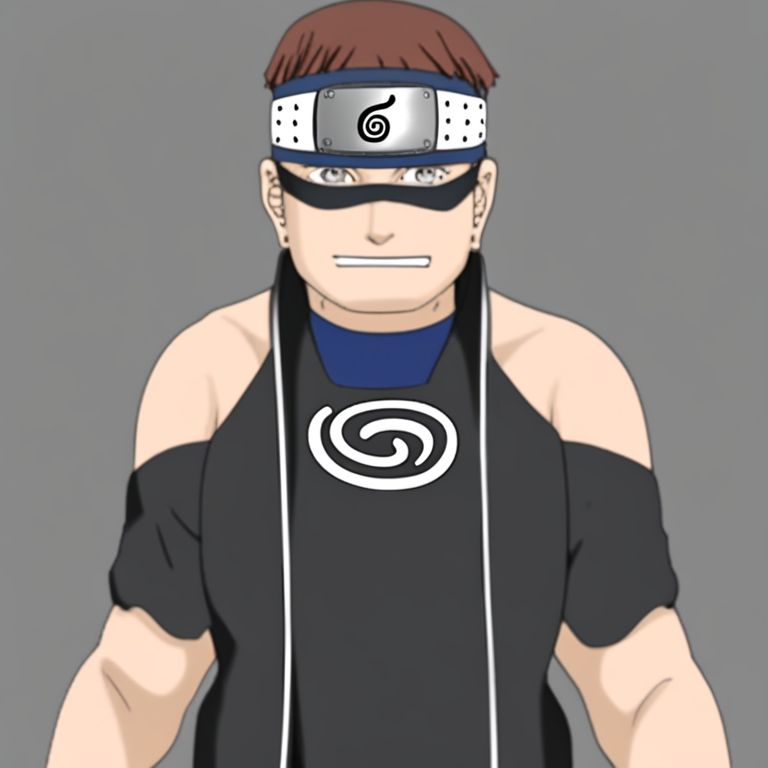

naruto style,bill gates


In [ ]:

import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection
from peft import PeftModel

# model configurations
MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
LORA_PATH = "/content/naruto_ultra/checkpoint-350"

#load the pipelines
print("Loading SDXL base models...")

pipe = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    variant="fp16"
).to("cuda")

print("Loading LoRA weights...")

#load unet lora
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_PATH)
pipe.unet = pipe.unet.merge_and_unload()


# Optimizations
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_vae_slicing()

print("All LoRA loaded!")

# ---------------- GENERATE ----------------
prompt = "naruto style,bill gates"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

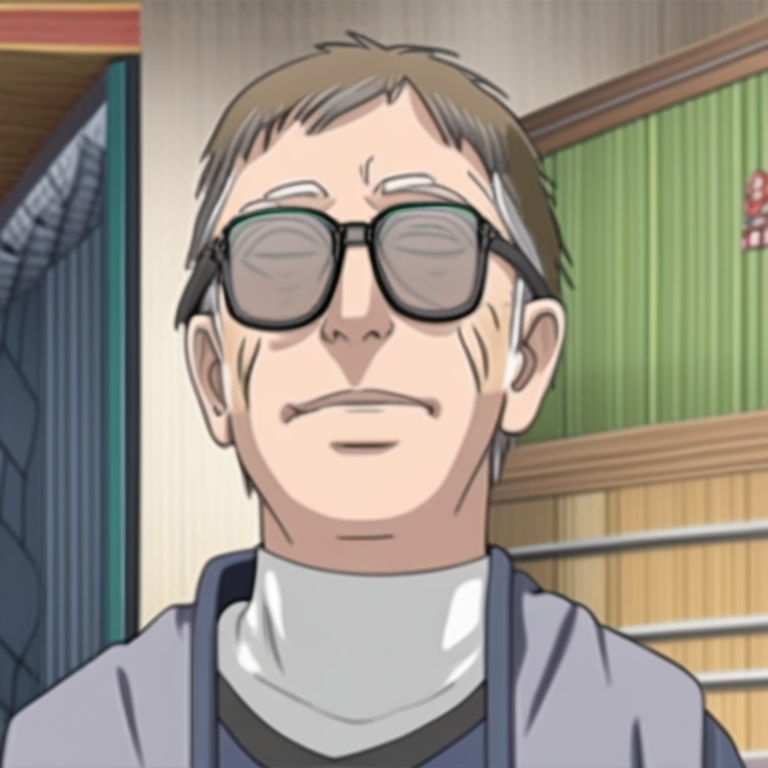

bill gates in naruto style


In [ ]:

prompt = "bill gates in naruto style"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

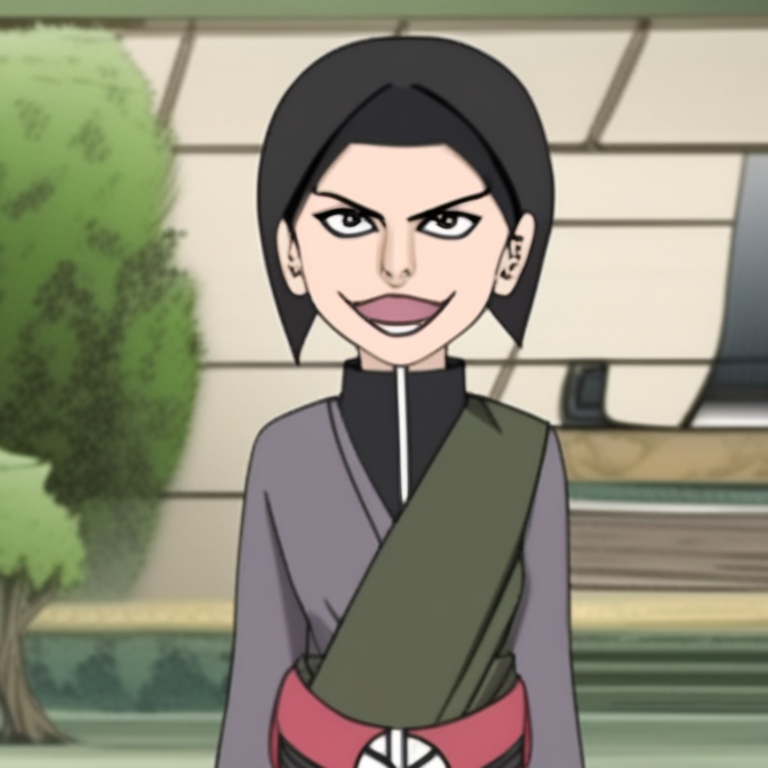

priyanka chopra in naruto style


In [ ]:

prompt = "priyanka chopra in naruto style"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

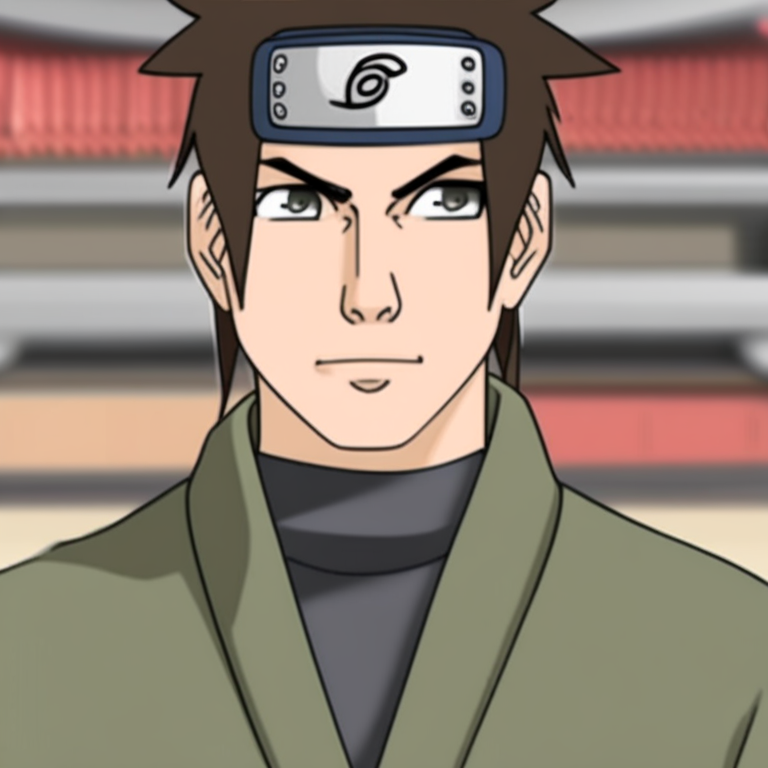

tom cruise in naruto style


In [ ]:
prompt = "tom cruise in naruto style"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

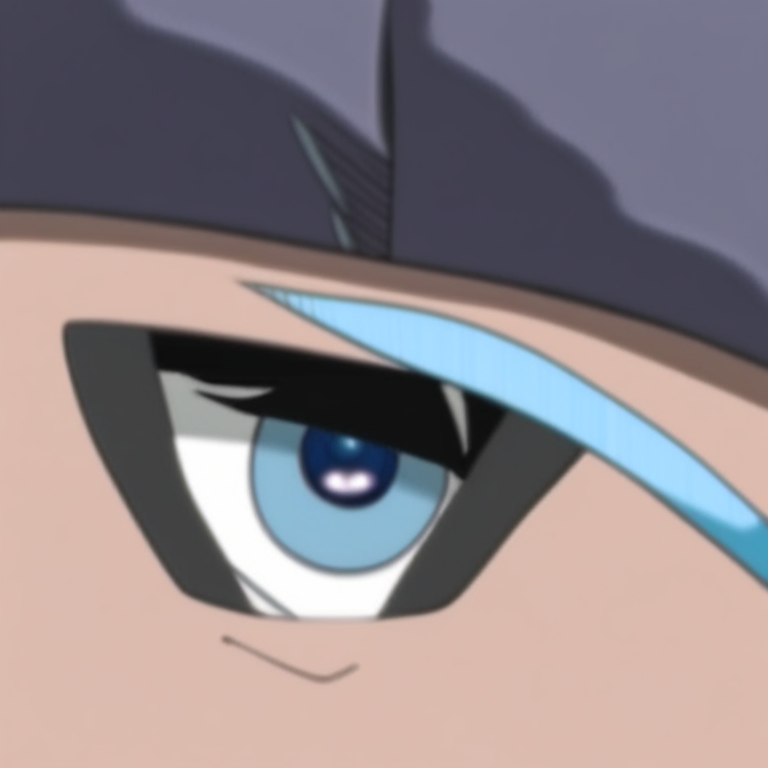

a boy with blue eyes in naruto style


In [ ]:

prompt = "a boy with blue eyes in naruto style"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

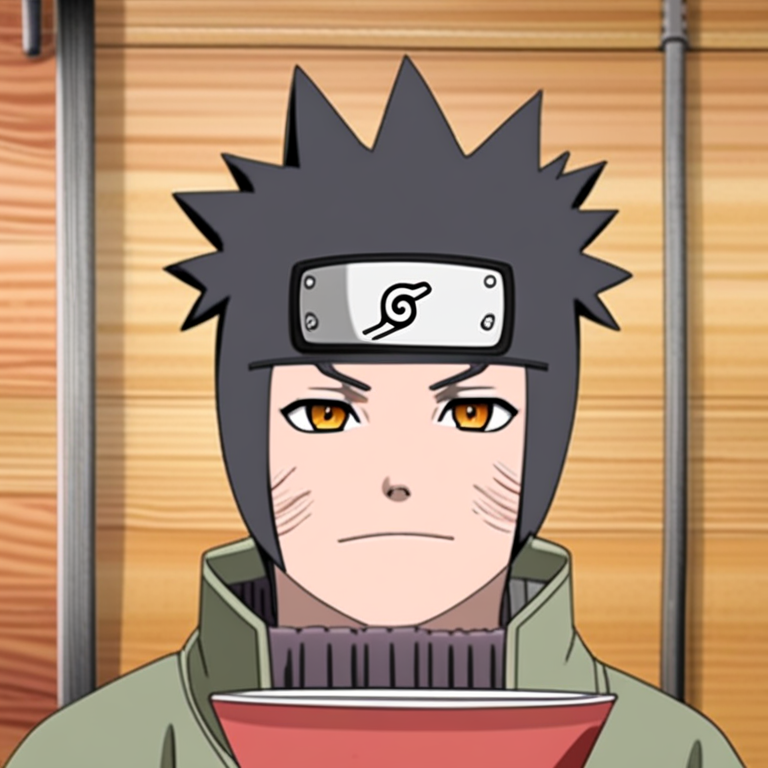

naruto eating ramen


In [ ]:

prompt = "naruto eating ramen"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

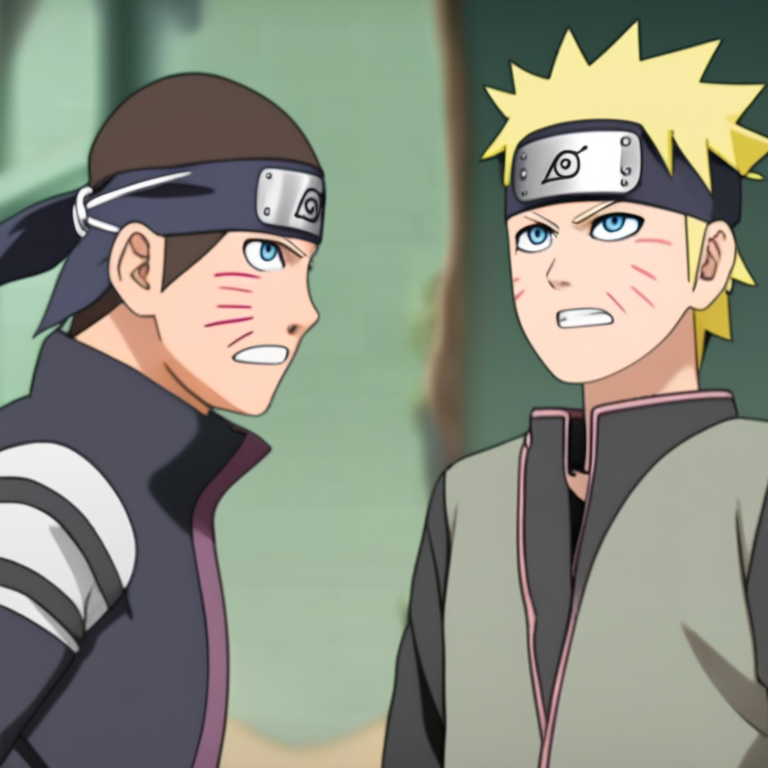

naruto styel, naruto and boruto fighting


In [ ]:

prompt = "naruto styel, naruto and boruto fighting"

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=768,
    width=768
).images[0]

display(image)
print(prompt)

In [ ]:
from google.colab import files
!zip -r /content/naruto_dora.zip /content/naruto_ultra
files.download('/content/naruto_dora.zip')


  adding: content/naruto_ultra/ (stored 0%)
  adding: content/naruto_ultra/checkpoint-200/ (stored 0%)
  adding: content/naruto_ultra/checkpoint-200/adapter_config.json (deflated 57%)
  adding: content/naruto_ultra/checkpoint-200/training_state.json (deflated 19%)
  adding: content/naruto_ultra/checkpoint-200/adapter_model.safetensors (deflated 7%)
  adding: content/naruto_ultra/checkpoint-200/README.md (deflated 66%)
  adding: content/naruto_ultra/checkpoint-100/ (stored 0%)
  adding: content/naruto_ultra/checkpoint-100/adapter_config.json (deflated 57%)
  adding: content/naruto_ultra/checkpoint-100/training_state.json (deflated 19%)
  adding: content/naruto_ultra/checkpoint-100/adapter_model.safetensors (deflated 7%)
  adding: content/naruto_ultra/checkpoint-100/README.md (deflated 66%)
  adding: content/naruto_ultra/checkpoint-350/ (stored 0%)
  adding: content/naruto_ultra/checkpoint-350/adapter_config.json (deflated 57%)
  adding: content/naruto_ultra/checkpoint-350/training_state

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>